# Build the model

In [1]:
from models.AttentionUnet import AttU_Net, U_Net
import torch
import torch.nn as nn
model = AttU_Net(num_classes=32, checkpoint=False).cuda()

initialize network with normal


# Create the dataset loader

In [2]:
import os
from torch.utils.data import DataLoader
from dataset.data_config.Camvid import CamVidDataset

# 设置数据集路径
# 根据自己的路径来设置
DATA_DIR = r'dataset\CamVid' 
x_train_dir = os.path.join(DATA_DIR, 'train')
y_train_dir = os.path.join(DATA_DIR, 'train_labels')

x_val_dir = os.path.join(DATA_DIR, 'val')
y_val_dir = os.path.join(DATA_DIR, 'val_labels')

x_test_dir = os.path.join(DATA_DIR, 'test')
y_test_dir = os.path.join(DATA_DIR, 'test_labels')
    
train_dataset = CamVidDataset(
    x_train_dir, 
    y_train_dir, 
)

val_dataset = CamVidDataset(
    x_val_dir, 
    y_val_dir, 
)

test_dataset = CamVidDataset(
    x_test_dir, 
    y_test_dir, 
)
 
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, drop_last=False)

# train

In [ ]:
from d2l import torch as d2l
import pandas as pd
import numpy as np
import os
from utils.train_utils import evaluate_loss
# training loop 100 epochs
epochs_num = 100
# 选用SGD优化器来训练
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
# 随便选一个学习率优化器
schedule = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[30,80], gamma=0.5)
# 损失函选用多分类交叉熵损失函数
loss_func = nn.CrossEntropyLoss(ignore_index=255)
device = torch.device("cuda:0")

# 训练函数
def train_model(model, train_iter, val_iter, loss_func, optimizer, num_epochs, schedule, device=device):
    
    timer, num_batches = d2l.Timer(), len(train_iter)
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0, 1], legend=['train loss', 'train acc', 'val loss', 'val acc'])
    model = model.to(device)
    
    # 用来保存一些训练参数
    train_loss_list = []
    val_loss_list = []
    train_acc_list = []
    val_acc_list = []
    epochs_list = []
    time_list = []
    lr_list = []

    for epoch in range(num_epochs):
        # Sum of training loss, sum of training accuracy, no. of examples,
        # no. of predictions
        metric = d2l.Accumulator(4)
        for i, (X, labels) in enumerate(train_iter):
            timer.start()

            if isinstance(X, list):
                X = [x.to(device) for x in X]
            else:
                X = X.to(device)
            gt = labels.long().to(device)

            model.train()
            optimizer.zero_grad()
            result = model(X)
            loss_sum = loss_func(result, gt)
            loss_sum.sum().backward()
            optimizer.step()
            acc = d2l.accuracy(result, gt)
            metric.add(loss_sum, acc, labels.shape[0], labels.numel())

            timer.stop()
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches, (metric[0] / metric[2], metric[1] / metric[3], None, None))
                
        schedule.step()
        val_acc = d2l.evaluate_accuracy_gpu(model, val_iter, device=device)
        val_loss = evaluate_loss(model, val_iter, loss_func, device=device)

        animator.add(epoch + 1, (None, None, val_loss, val_acc))
        print(f"epoch {epoch+1}/{epochs_num} --- train loss {metric[0] / metric[2]:.3f} --- train acc {metric[1] / metric[3]:.3f} --- val loss {val_loss:.3f} --- val acc {val_acc:.3f} --- lr {optimizer.state_dict()['param_groups'][0]['lr']} --- cost time {timer.sum()}")
        
        #---------保存训练数据---------------
        df = pd.DataFrame()
        train_loss_list.append(metric[0] / metric[2])
        val_loss_list.append(val_loss)
        
        train_acc_list.append(metric[1] / metric[3])
        val_acc_list.append(val_acc)
        epochs_list.append(epoch+1)
        time_list.append(timer.sum())
        lr_list.append(optimizer.state_dict()['param_groups'][0]['lr'])
        
        df['epoch'] = epochs_list
        df['train_loss'] = train_loss_list
        df['val_loss'] = val_loss_list
        df['train_acc'] = train_acc_list
        df['val_acc'] = val_acc_list
        df["lr"] = lr_list
        df['time'] = time_list
        
        df.to_excel("trash/TransUnet_camvid.xlsx")
        #----------------保存模型------------------- 
        if np.mod(epoch+1, 5) == 0:
            torch.save(model.state_dict(), f'trash/TransUnet_{epoch+1}.pth')

    # 保存下最后的model
    torch.save(model.state_dict(), f'trash/TransUnet_last.pth')

train_model(model, train_loader, val_loader, loss_func, optimizer, epochs_num, schedule, device)

# Test

In [ ]:
from utils.train_utils import test_gpu, show_result_pyplot, inference_model
seg_pred, acc = test_gpu(model, test_loader, device=torch.device("cuda:0"))
print(acc)
# img_path = r"E:\segmentation\dataset\CamVid\test/0001TP_006780.png"
# show_result_pyplot(model, img_path, result = seg_pred[0])

0.13595385621921183


# Inference

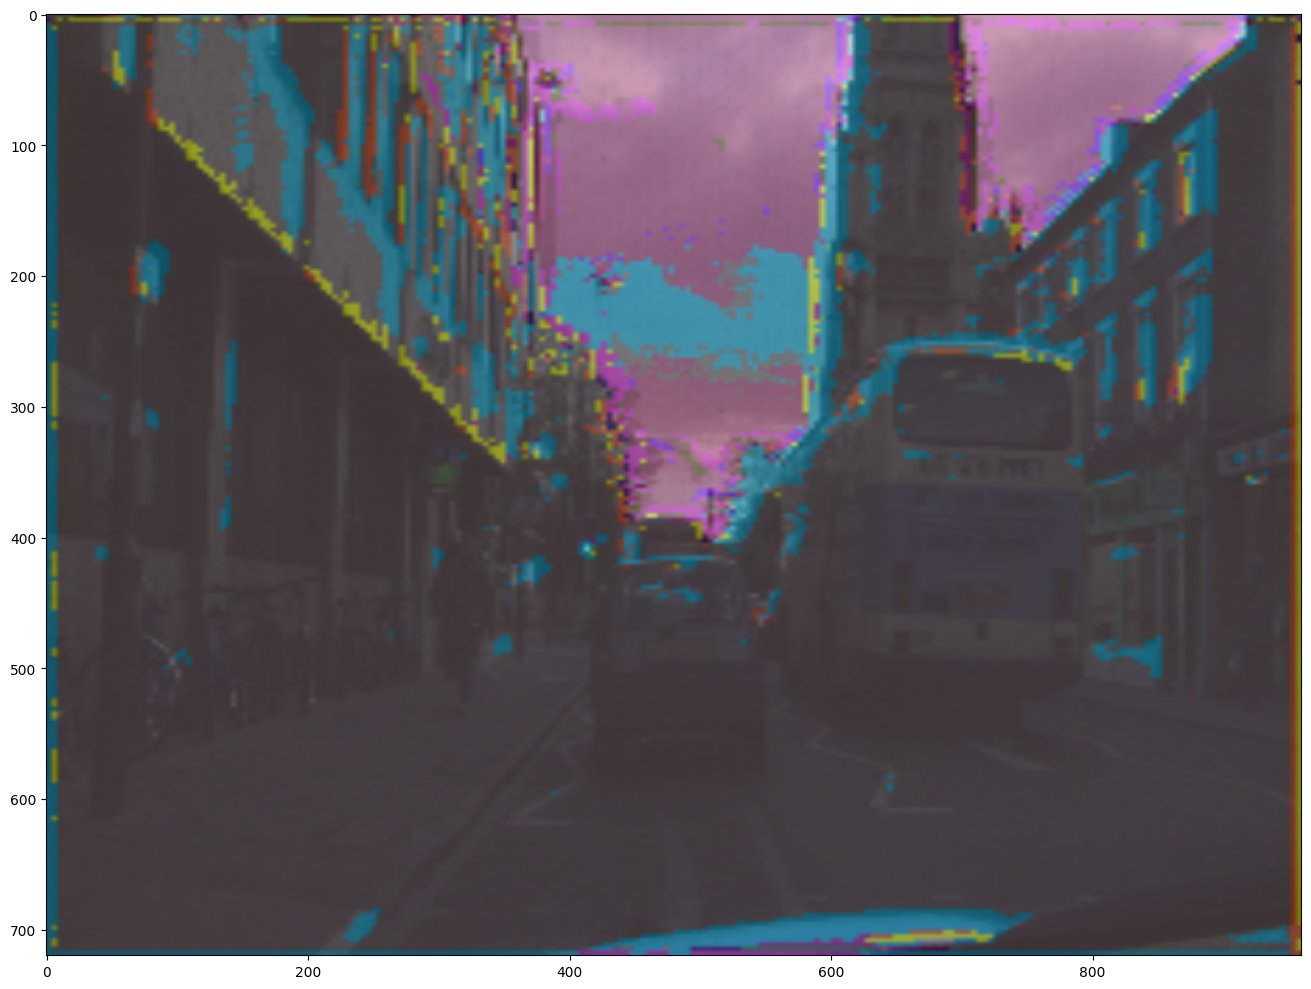

In [5]:
from utils.train_utils import inference_model, show_result_pyplot
        
img_path = r"E:\segmentation\dataset\CamVid\test/0001TP_006780.png"
result = inference_model(model, img_path)
show_result_pyplot(model, img_path, result = result, opacity=0.5)